# Exe_26 - RDKit - Decision Tree

In [1]:
conda install -c conda-forge dtreeviz

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 22.11.1

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /Users/sashaolshanova/opt/anaconda3/envs/my-rdkit-env

  added / updated specs:
    - dtreeviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    appdirs-1.4.4              |     pyh9f0ad1d_0          13 KB  conda-forge
    atk-1.0-2.38.0             |       h1d18e73_1         359 KB  conda-forge
    brotlipy-0.7.0             |py311h5547dcb_1005         370 KB  conda-forge
    charset-normalizer-2.1.1   |     pyhd8ed1ab_0          36 KB  conda-forge
    colorama-0.4.6             |     pyhd8ed1ab_0          25 KB  conda-forge
    colour-0.1.5               |             py_0          17 KB  conda-forge
    cryptography-39.0.0        |  p

In [1]:
import pandas as pd #data table manipulation
from rdkit import Chem # basic cheminformatics
from rdkit.Chem.Descriptors import MolWt, MolLogP, NumAromaticRings, NumHDonors, NumHAcceptors
import math #needed for log10
import seaborn as sns #plotting
from sklearn.tree import DecisionTreeClassifier, plot_tree # descision trees 
from sklearn.model_selection import train_test_split # split a dataset
from tqdm import tqdm # progress bar
from matplotlib import pyplot as plt # plotting
from dtreeviz.trees import * #plotting decision trees
from sklearn.metrics import roc_auc_score, matthews_corrcoef, cohen_kappa_score, RocCurveDisplay, ConfusionMatrixDisplay # model stats
from tqdm import tqdm

Enable Pandas **progress_apply**

In [2]:
tqdm.pandas()

A simple function to calculate molecular weight, LogP, number of aromatic rings, number of hydrogen bond donors and acceptors from a SMILES

In [3]:
def calc_descriptors(smi):
    mol = Chem.MolFromSmiles(smi)
    if mol:
        mw, logp, num_arom_rings, hbd, hba = [x(mol) for x in [MolWt, MolLogP, NumAromaticRings, NumHDonors, NumHAcceptors]]
        res = [mw, logp, num_arom_rings, hbd, hba]
    else:
        res = [None] * 5
    return res

### The Data

In [4]:
df = pd.read_csv("delaney.csv")

**Get the dataframe column names**

In [5]:
df.columns

Index(['Compound ID', 'measured log(solubility:mol/L)',
       'ESOL predicted log(solubility:mol/L)', 'SMILES'],
      dtype='object')

'ESOL predicted log(solubility:mol/L)' - Method for estimating the aqueous solubility (ESOL--Estimated SOLubility) of a compound directly from its structure.

**Change the name of column 1 to "LogS"**

In [9]:
cols = list(df.columns)
cols[1] = 'LogS'
df.columns = cols
cols

['Compound ID', 'LogS', 'ESOL predicted log(solubility:mol/L)', 'SMILES']

**Add a new column "IsSol" to indicate whether a molecule's solubility is greater than 200uM**

In [10]:
df['IsSol'] = df.LogS > math.log10(200 * 1e-6)
df.head()

,Compound ID,LogS,ESOL predicted log(solubility:mol/L),SMILES,IsSol
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl,True
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl,True
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl,True
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl,True
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl,True


**Plot solubility as a sanity check**

In [11]:
sns.set(rc={'figure.figsize': (10, 10)})
sns.set_style('whitegrid')
sns.set_context('talk')

<Figure size 1000x600 with 0 Axes>

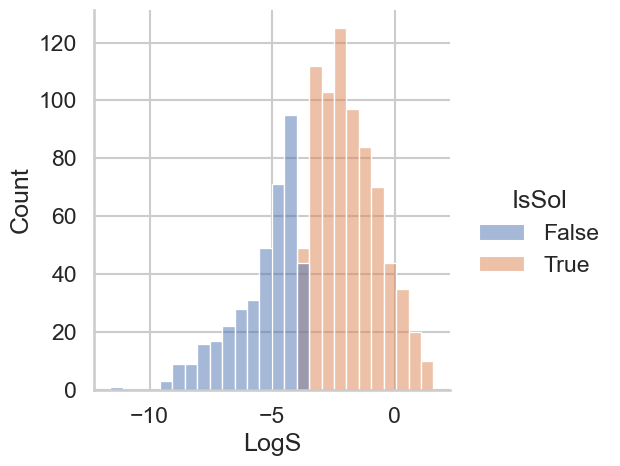

In [12]:
fig = plt.figure(figsize=(10,6))
sns.displot(x='LogS',hue="IsSol",data=df)

**Add the descriptors to the dataframe.  Note that all of the descriptors are going into one column called "desc":**

In [13]:
df['desc'] = df.SMILES.progress_apply(calc_descriptors)
df.head()

100%|██████████| 1144/1144 [00:00<00:00, 1782.96it/s]


,Compound ID,LogS,ESOL predicted log(solubility:mol/L),SMILES,IsSol,desc
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl,True,"[167.85, 2.5954000000000006, 0, 0, 0]"
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl,True,"[133.405, 2.376500000000001, 0, 0, 0]"
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl,True,"[167.85, 2.5938, 0, 0, 0]"
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl,True,"[133.405, 2.0289, 0, 0, 0]"
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl,True,"[187.37500000000003, 2.9189, 0, 0, 0]"


**Split the descriptors into their on own columns:**

In [14]:
df[['MW','LogP','NumAromatic','HBD','HBA']] =  pd.DataFrame(df.desc.tolist(), index= df.index)
df.head()

,Compound ID,LogS,ESOL predicted log(solubility:mol/L),SMILES,IsSol,desc,MW,LogP,NumAromatic,HBD,HBA
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl,True,"[167.85, 2.5954000000000006, 0, 0, 0]",167.850,2.5954,0,0,0
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl,True,"[133.405, 2.376500000000001, 0, 0, 0]",133.405,2.3765,0,0,0
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl,True,"[167.85, 2.5938, 0, 0, 0]",167.850,2.5938,0,0,0
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl,True,"[133.405, 2.0289, 0, 0, 0]",133.405,2.0289,0,0,0
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl,True,"[187.37500000000003, 2.9189, 0, 0, 0]",187.375,2.9189,0,0,0


In [15]:
desc_cols = ['MW','LogP','NumAromatic','HBD','HBA']
# df[desc_cols] = df.desc.to_list()

**We no longer need the "desc" column, let's get rid of it: **

In [16]:
df.drop("desc",axis=1,inplace=True)

**Let's check the dataframe to make sure it's ok:** 

In [17]:
df

,Compound ID,LogS,ESOL predicted log(solubility:mol/L),SMILES,IsSol,MW,LogP,NumAromatic,HBD,HBA
0,"1,1,1,2-Tetrachloroethane",-2.180,-2.794,ClCC(Cl)(Cl)Cl,True,167.850,2.59540,0,0,0
1,"1,1,1-Trichloroethane",-2.000,-2.232,CC(Cl)(Cl)Cl,True,133.405,2.37650,0,0,0
2,"1,1,2,2-Tetrachloroethane",-1.740,-2.549,ClC(Cl)C(Cl)Cl,True,167.850,2.59380,0,0,0
3,"1,1,2-Trichloroethane",-1.480,-1.961,ClCC(Cl)Cl,True,133.405,2.02890,0,0,0
4,"1,1,2-Trichlorotrifluoroethane",-3.040,-3.077,FC(F)(Cl)C(F)(Cl)Cl,True,187.375,2.91890,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1139,vamidothion,1.144,-1.446,CNC(=O)C(C)SCCSP(=O)(OC)(OC),True,287.343,1.98820,0,1,6
1140,Vinclozolin,-4.925,-4.377,CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C,False,286.114,3.42130,1,0,3
1141,Warfarin,-3.893,-3.913,CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O,False,308.333,3.60960,3,1,4
1142,Xipamide,-3.790,-3.642,Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O,False,354.815,2.56214,2,3,4


**Split the data into training and test sets:** 

In [17]:
train, test = train_test_split(df) #train - 75%, test - 25%

**Split the training and test sets into X and y variables:** 

In [18]:
train_X = train[desc_cols]
train_y = train.IsSol
test_X = test[desc_cols]
test_y = test.IsSol

**Create and train a classifier:**

In [19]:
cls = DecisionTreeClassifier(max_depth=2)
cls.fit(train_X,train_y)

DecisionTreeClassifier(max_depth=2)

**Predict on the test set:**

In [20]:
pred = cls.predict(test_X)
auc = roc_auc_score(test_y, pred)
print(f"ROC AUC = {auc:.2f}")

ROC AUC = 0.84


**Plot a confusion matrix to show the classifier performance:**

In [21]:
from sklearn.metrics import classification_report,confusion_matrix

In [22]:
print(confusion_matrix(test_y,pred))

[[ 67  26]
 [  9 184]]


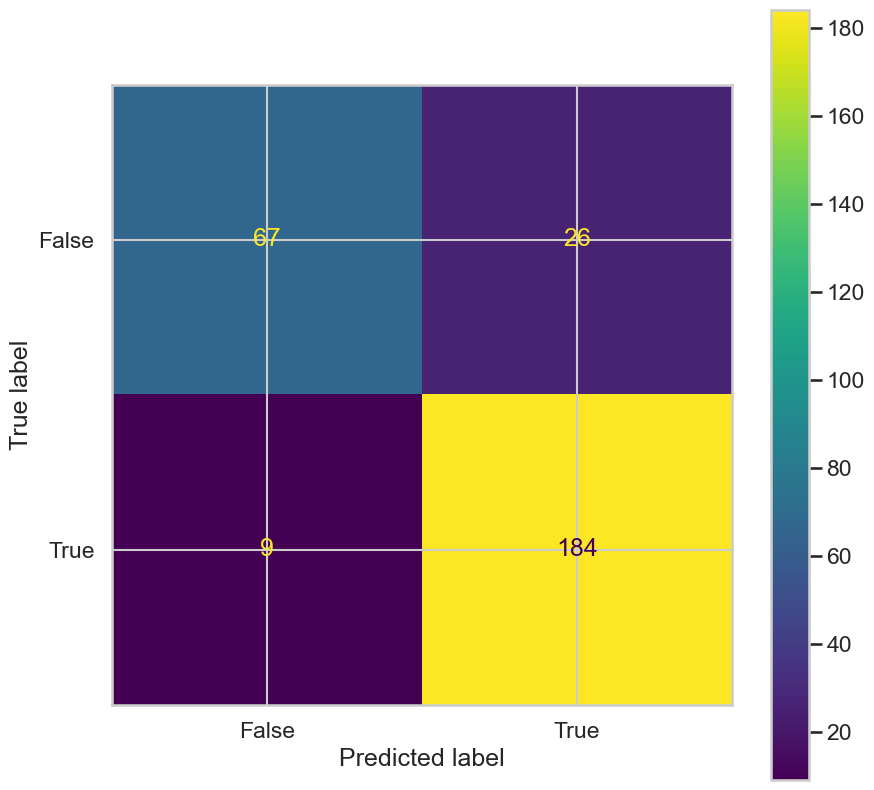

In [28]:
ConfusionMatrixDisplay.from_estimator(cls,test_X,test_y)

**Plot an ROC cure to show the classifier performance:**

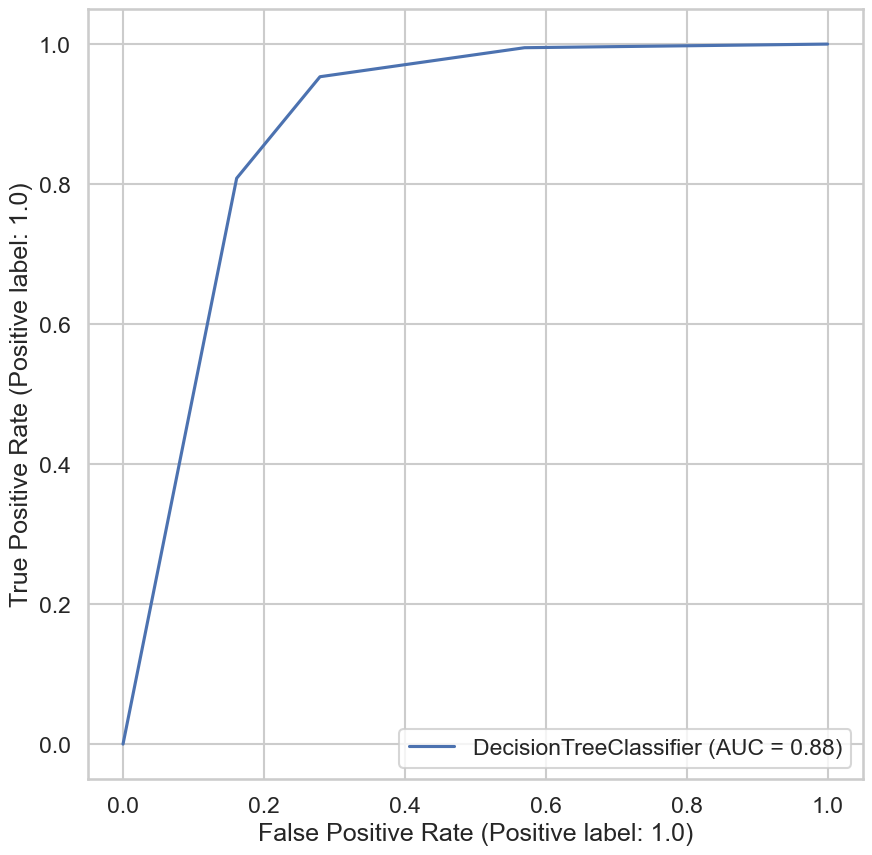

In [27]:
RocCurveDisplay.from_estimator(cls,test_X,test_y)

Use the default view from SciKit Learn to plot the decision tree

[Text(0.5, 0.8333333333333334, 'LogP <= 3.11\ngini = 0.456\nsamples = 858\nvalue = [302, 556]'),
 Text(0.25, 0.5, 'MW <= 236.486\ngini = 0.18\nsamples = 580\nvalue = [58, 522]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.079\nsamples = 461\nvalue = [19, 442]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.441\nsamples = 119\nvalue = [39, 80]'),
 Text(0.75, 0.5, 'LogP <= 4.006\ngini = 0.215\nsamples = 278\nvalue = [244, 34]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.379\nsamples = 134\nvalue = [100, 34]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.0\nsamples = 144\nvalue = [144, 0]')]

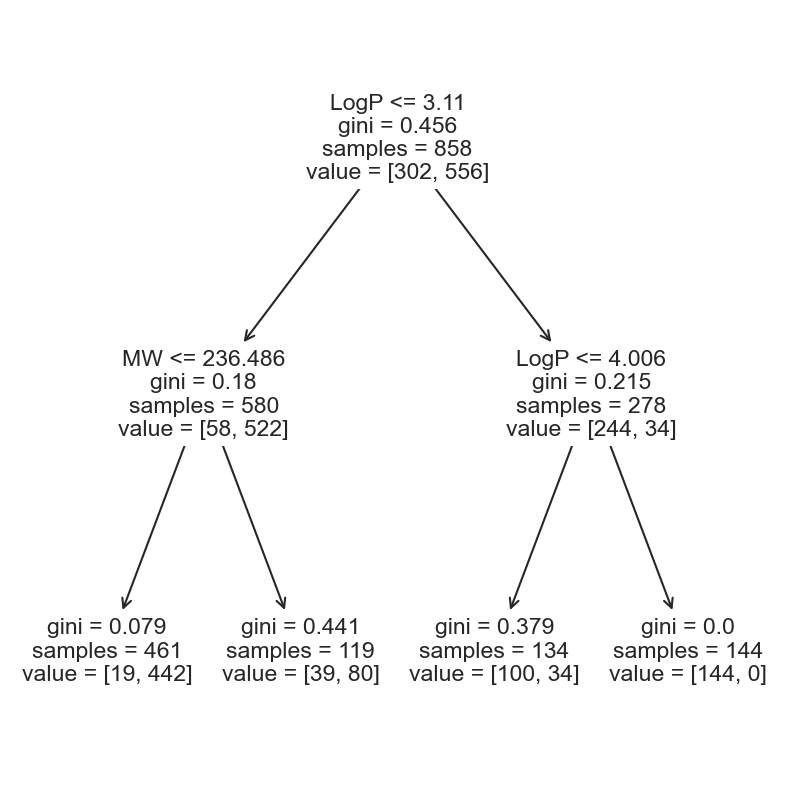

In [29]:
# plt.rcParams["figure.figsize"] = (10,10)
plot_tree(cls,feature_names=desc_cols)